In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint 
from collections import Counter
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, mixed_precision, regularizers
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import pandas as pd
from tensorflow.keras.regularizers import l2

2025-05-05 03:57:26.794916: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746397646.900767    2296 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746397646.929122    2296 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746397647.175621    2296 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746397647.175641    2296 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746397647.175643    2296 computation_placer.cc:177] computation placer alr

In [2]:
tf.__version__

'2.19.0'

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)  
    except RuntimeError as e:
        print(e)

In [4]:
mixed_precision.set_global_policy("mixed_float16")

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "dataPrep/processed",
    shuffle=True,
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb"
)

Found 27024 files belonging to 19 classes.


I0000 00:00:1746371648.877241   14142 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
N_CLASSES = len(dataset.class_names)

In [11]:
N_CLASSES

19

In [8]:
CLASS_NAMES = dataset.class_names

In [9]:
CLASS_NAMES


['aloe__healthy',
 'aloe__leaf_spot',
 'aloe__rust',
 'aloe__sunburn',
 'aloe_anthracnose',
 'moneyplant__bacterial_wilt',
 'moneyplant__manganese_toxicity',
 'moneyplant_healthy',
 'potato___early_blight',
 'potato___healthy',
 'potato___late_blight',
 'tomato__bacterial_spot',
 'tomato__early_blight',
 'tomato__healthy',
 'tomato__late_blight',
 'tomato__leaf_mold',
 'tomato__septoria_leaf_spot',
 'tomato__target_spot',
 'tomato__tomato_mosaic_virus']

In [10]:
num_classes = len(dataset.class_names)
label_counts = Counter()
for _, labels in dataset:
    label_counts.update(labels.numpy())

total_samples = sum(label_counts.values())
label_counts = {i: label_counts.get(i, 1) for i in range(num_classes)}
class_weights = {i: total_samples / (num_classes * count) for i, count in label_counts.items()}

print("Class Weights:", class_weights)

2025-05-04 20:44:32.171449: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37601280 exceeds 10% of free system memory.
2025-05-04 20:44:32.223983: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37601280 exceeds 10% of free system memory.
2025-05-04 20:44:32.224406: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36578304 exceeds 10% of free system memory.
2025-05-04 20:44:32.272766: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 37601280 exceeds 10% of free system memory.
2025-05-04 20:44:32.279369: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 36578304 exceeds 10% of free system memory.


Class Weights: {0: 1.8352461799660442, 1: 2.867572156196944, 2: 6.805338705615714, 3: 2.8164669098488795, 4: 2.8791817600681866, 5: 0.3398604036974156, 6: 0.4687922839399091, 7: 0.34614645643068487, 8: 1.4294631049986777, 9: 9.482105263157894, 10: 1.4223157894736842, 11: 0.6693250773993809, 12: 1.4251661217171185, 13: 0.8956648548322949, 14: 0.7513554091250313, 15: 1.495600199236261, 16: 0.805844639928433, 17: 1.0299172986775411, 18: 3.833735281600227}


2025-05-04 20:44:39.858299: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
def split_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=123)

    ds_size = len(ds)
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)
# train_ds = train_ds.batch(BATCH_SIZE).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# data_augmentation = keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),
#     layers.RandomBrightness(0.2),
# ])

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
])


model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=regularizers.l2(0.0005), input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3), 

    layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),  
    layers.Dense(N_CLASSES, activation='softmax')
])


optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,  
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.build(input_shape=input_shape)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)     

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True  
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,        
    patience=3,        
    min_lr=1e-6        
)
model_checkpoint = ModelCheckpoint(
    "best_model_10",  
    monitor="val_loss",
    save_best_only=True,  
    verbose=1
)

In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True, to_file="model_structure.png")

In [26]:
train_history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler,model_checkpoint],
)

Epoch 1/20
676/676 [==============================] - ETA: 0s - loss: 1.9761 - accuracy: 0.4612      
Epoch 1: val_loss improved from inf to 2.18178, saving model to best_model_10


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


676/676 [==============================] - 692s 925ms/step - loss: 1.9761 - accuracy: 0.4612 - val_loss: 2.1818 - val_accuracy: 0.4416 - lr: 0.0010
Epoch 2/20
676/676 [==============================] - ETA: 0s - loss: 1.5886 - accuracy: 0.5826   
Epoch 2: val_loss improved from 2.18178 to 1.68447, saving model to best_model_10


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


676/676 [==============================] - 585s 865ms/step - loss: 1.5886 - accuracy: 0.5826 - val_loss: 1.6845 - val_accuracy: 0.5423 - lr: 0.0010
Epoch 3/20
676/676 [==============================] - ETA: 0s - loss: 1.2971 - accuracy: 0.6708   
Epoch 3: val_loss did not improve from 1.68447
676/676 [==============================] - 544s 804ms/step - loss: 1.2971 - accuracy: 0.6708 - val_loss: 2.3557 - val_accuracy: 0.4835 - lr: 0.0010
Epoch 4/20
676/676 [==============================] - ETA: 0s - loss: 1.1844 - accuracy: 0.7185  
Epoch 4: val_loss did not improve from 1.68447
676/676 [==============================] - 543s 803ms/step - loss: 1.1844 - accuracy: 0.7185 - val_loss: 1.8301 - val_accuracy: 0.4862 - lr: 0.0010
Epoch 5/20
676/676 [==============================] - ETA: 0s - loss: 1.0325 - accuracy: 0.7688  
Epoch 5: val_loss improved from 1.68447 to 1.03908, saving model to best_model_10


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


676/676 [==============================] - 555s 821ms/step - loss: 1.0325 - accuracy: 0.7688 - val_loss: 1.0391 - val_accuracy: 0.7028 - lr: 0.0010
Epoch 6/20
676/676 [==============================] - ETA: 0s - loss: 0.9600 - accuracy: 0.7935   
Epoch 6: val_loss improved from 1.03908 to 0.94291, saving model to best_model_10


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


676/676 [==============================] - 571s 843ms/step - loss: 0.9600 - accuracy: 0.7935 - val_loss: 0.9429 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 7/20
676/676 [==============================] - ETA: 0s - loss: 0.8977 - accuracy: 0.8149   
Epoch 7: val_loss did not improve from 0.94291
676/676 [==============================] - 580s 858ms/step - loss: 0.8977 - accuracy: 0.8149 - val_loss: 1.4355 - val_accuracy: 0.6486 - lr: 0.0010
Epoch 8/20
676/676 [==============================] - ETA: 0s - loss: 0.8813 - accuracy: 0.8221  
Epoch 8: val_loss did not improve from 0.94291
676/676 [==============================] - 557s 824ms/step - loss: 0.8813 - accuracy: 0.8221 - val_loss: 1.3026 - val_accuracy: 0.6965 - lr: 0.0010
Epoch 9/20
676/676 [==============================] - ETA: 0s - loss: 0.8553 - accuracy: 0.8290  
Epoch 9: val_loss did not improve from 0.94291
676/676 [==============================] - 538s 795ms/step - loss: 0.8553 - accuracy: 0.8290 - val_loss: 1.6879 - val_ac

INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


676/676 [==============================] - 563s 833ms/step - loss: 0.7082 - accuracy: 0.8710 - val_loss: 0.7187 - val_accuracy: 0.8189 - lr: 5.0000e-04
Epoch 11/20
676/676 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.8752   
Epoch 11: val_loss did not improve from 0.71872
676/676 [==============================] - 540s 798ms/step - loss: 0.6825 - accuracy: 0.8752 - val_loss: 0.8418 - val_accuracy: 0.7807 - lr: 5.0000e-04
Epoch 12/20
676/676 [==============================] - ETA: 0s - loss: 0.6348 - accuracy: 0.8830  
Epoch 12: val_loss did not improve from 0.71872
676/676 [==============================] - 539s 797ms/step - loss: 0.6348 - accuracy: 0.8830 - val_loss: 0.8639 - val_accuracy: 0.7691 - lr: 5.0000e-04
Epoch 13/20
676/676 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.8853  
Epoch 13: val_loss did not improve from 0.71872
676/676 [==============================] - 542s 802ms/step - loss: 0.6307 - accuracy: 0.8853 - val_los

In [37]:
scores = model.evaluate(test_ds)

85/85 [==============================] - 69s 45ms/step - loss: 0.7443 - accuracy: 0.7993


In [38]:
scores

[0.7443305850028992, 0.7992647290229797]

In [29]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

In [30]:
acc

[0.46116864681243896,
 0.5825628638267517,
 0.6708117723464966,
 0.718518853187561,
 0.7687684893608093,
 0.7934541702270508,
 0.8148576021194458,
 0.8221153616905212,
 0.8289570808410645,
 0.8710244297981262,
 0.8751848936080933,
 0.8829512000083923,
 0.8852625489234924,
 0.906481146812439,
 0.9112426042556763]

In [43]:
val_acc

[0.4416167736053467,
 0.5422903895378113,
 0.48353293538093567,
 0.486152708530426,
 0.7028443217277527,
 0.7305389046669006,
 0.648577868938446,
 0.6964820623397827,
 0.6133981943130493,
 0.81886225938797,
 0.7806886434555054,
 0.7690868377685547,
 0.7994012236595154,
 0.8046407103538513,
 0.7282934188842773]

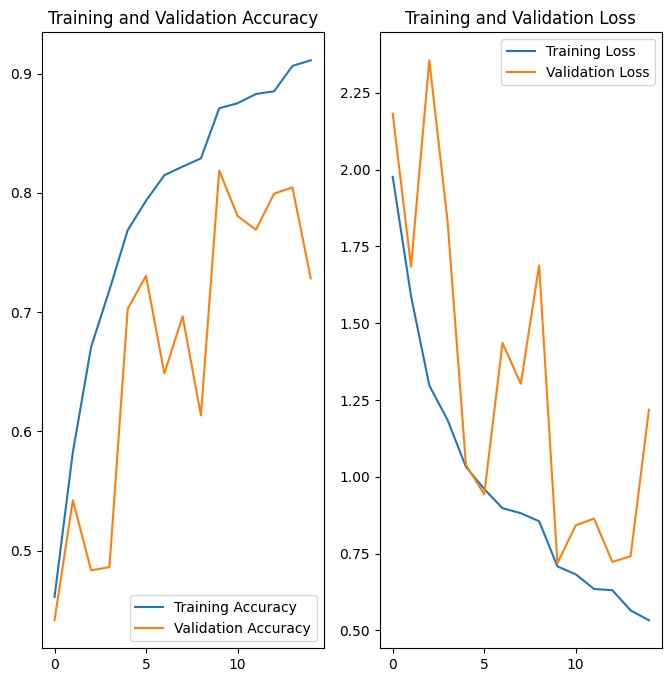

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

85/85 [==============================] - 3s 28ms/step


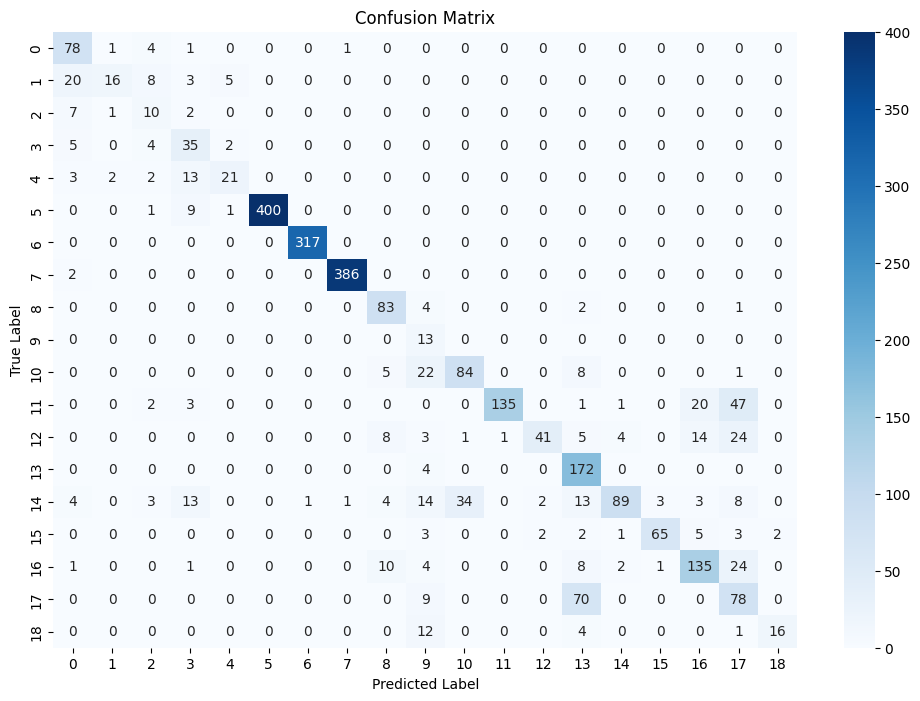

In [39]:

# Get predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


C:\Users\Chirag_70\AppData\Local\Temp\ipykernel_23644\515823600.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=CLASS_NAMES, y=class_accuracy, palette="viridis")


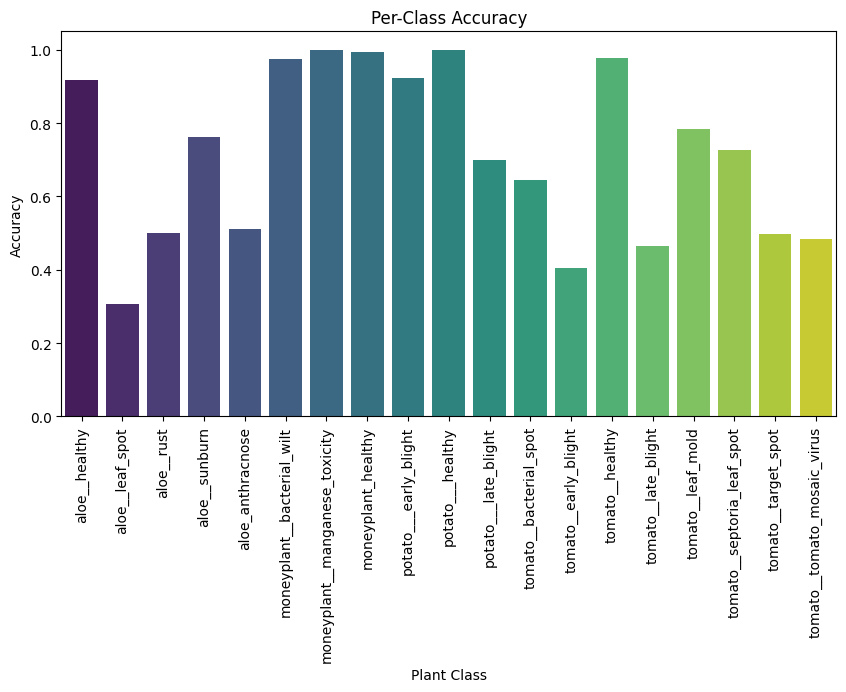

In [40]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Create bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=CLASS_NAMES, y=class_accuracy, palette="viridis")
plt.xlabel("Plant Class")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(rotation=90)
plt.show()

In [41]:
model.save(f"../models/10.h5")
model.save(f"../models/10")

INFO:tensorflow:Assets written to: ../models/10\assets


INFO:tensorflow:Assets written to: ../models/10\assets
